In [1]:
# 导包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score, roc_curve, auc, confusion_matrix
from plot_confusion_matrix import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
# 读取数据
# 根据题意，先把header设置好
headers = ['age', 'workclass', 'fnlwgt',
           'education', 'education_num', 'marital_status',
           'occupation', 'relationship', 'race',
           'sex', 'capital_gain', 'capital_loss',
           'hours_per_week', 'native_country', 'income']

# 读取训练集进入内存
train_data = pd.read_csv("data/adult_train.csv",names=headers)

# 对于测试集，他的第一行是一个分隔，不读入
test_data = pd.read_csv("data/adult_test.csv",names=headers,skiprows=[0])
test_data['income']= test_data['income'].apply(lambda x: x[0:-1])

In [3]:
train_data['source']='train'
test_data['source']='test'

In [4]:
# 合并数据一起进行预处理
data= pd.concat([train_data, test_data],axis=0,ignore_index=True)
data = data.replace('[?]', np.NaN, regex=True)
data.dropna(inplace=True)

In [5]:
# 对缺失数据进行处理，删除
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
source            0
dtype: int64

In [6]:
# 开始处理离散数据
# income我们需要将其映射一下
# 先将>=50K的映射成1，<=50K的设置为0
le= LabelEncoder()
data['income']= le.fit_transform(data['income'])
data['income'].value_counts()


0    34014
1    11208
Name: income, dtype: int64

In [7]:
# 取出所有的离散量属性,这些属性先不用看我们自定义的数据来源那一项
discrete = [x for x in data.columns if data[x].dtype=='object']
discrete.remove('source')
discrete

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

In [8]:
# 看看这些离散量属性的取值分布
for i in discrete:
    print(data[i].value_counts())
    

 Private             33307
 Self-emp-not-inc     3796
 Local-gov            3100
 State-gov            1946
 Self-emp-inc         1646
 Federal-gov          1406
 Without-pay            21
Name: workclass, dtype: int64
 HS-grad         14783
 Some-college     9899
 Bachelors        7570
 Masters          2514
 Assoc-voc        1959
 11th             1619
 Assoc-acdm       1507
 10th             1223
 7th-8th           823
 Prof-school       785
 9th               676
 12th              577
 Doctorate         544
 5th-6th           449
 1st-4th           222
 Preschool          72
Name: education, dtype: int64
 Married-civ-spouse       21055
 Never-married            14598
 Divorced                  6297
 Separated                 1411
 Widowed                   1277
 Married-spouse-absent      552
 Married-AF-spouse           32
Name: marital_status, dtype: int64
 Craft-repair         6020
 Prof-specialty       6008
 Exec-managerial      5984
 Adm-clerical         5540
 Sales          

In [9]:
# 看看education_num这个连续量
data['education'].value_counts()

 HS-grad         14783
 Some-college     9899
 Bachelors        7570
 Masters          2514
 Assoc-voc        1959
 11th             1619
 Assoc-acdm       1507
 10th             1223
 7th-8th           823
 Prof-school       785
 9th               676
 12th              577
 Doctorate         544
 5th-6th           449
 1st-4th           222
 Preschool          72
Name: education, dtype: int64

In [10]:
# 发现跟education一样的，重复了，因为eudcation是离散的，不好处理。去掉这个属性
data = data.drop(columns=['education'])

In [11]:
# 看看相关系数矩阵,检查一下连续变量。发现序号属性不太影响最后的收入
data.corr()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income
age,1.000000,-0.075792,0.037623,0.079683,0.059351,0.101992,0.237040
fnlwgt,-0.075792,1.000000,-0.041993,-0.004110,-0.004349,-0.018679,-0.007264
education_num,0.037623,-0.041993,1.000000,0.126907,0.081711,0.146206,0.332800
capital_gain,0.079683,-0.004110,0.126907,1.000000,-0.032102,0.083880,0.221034
capital_loss,0.059351,-0.004349,0.081711,-0.032102,1.000000,0.054195,0.148687
hours_per_week,0.101992,-0.018679,0.146206,0.083880,0.054195,1.000000,0.227199
income,0.237040,-0.007264,0.332800,0.221034,0.148687,0.227199,1.000000


In [12]:
# 把序号属性删掉
data = data.drop(columns=['fnlwgt'])

In [13]:
discrete2 = [x for x in data.columns if data[x].dtype=='object']
discrete2.remove('source')
discrete2

['workclass',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

In [14]:
# 进行哑编码
data = pd.get_dummies(data, columns=discrete2, drop_first=True)

In [15]:
# 看看编码后的结果
data.columns

Index(['age', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'income', 'source', 'workclass_ Local-gov',
       'workclass_ Private', 'workclass_ Self-emp-inc',
       'workclass_ Self-emp-not-inc', 'workclass_ State-gov',
       'workclass_ Without-pay', 'marital_status_ Married-AF-spouse',
       'marital_status_ Married-civ-spouse',
       'marital_status_ Married-spouse-absent',
       'marital_status_ Never-married', 'marital_status_ Separated',
       'marital_status_ Widowed', 'occupation_ Armed-Forces',
       'occupation_ Craft-repair', 'occupation_ Exec-managerial',
       'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners',
       'occupation_ Machine-op-inspct', 'occupation_ Other-service',
       'occupation_ Priv-house-serv', 'occupation_ Prof-specialty',
       'occupation_ Protective-serv', 'occupation_ Sales',
       'occupation_ Tech-support', 'occupation_ Transport-moving',
       'relationship_ Not-in-family', 'relationship_ Oth

In [16]:
# 将非2值类型的数据进行标准化
num = [x for x in data.columns if data[x].dtype=='int64']
num

['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

In [17]:
scaler = StandardScaler()
data.loc[:, num] = scaler.fit_transform(data.loc[:, num])

In [18]:
train_data = data.loc[data['source']=='train',:]
test_data = data.loc[data['source']=='test',:]

In [19]:
# 把要预测的值income单独拿出来看看
y_train = np.array(train_data.income)
x_train = np.array(train_data.drop(['income','source'], axis=1))

y_test = np.array(test_data.income)
x_test = np.array(test_data.drop(['income','source'],axis=1))

In [20]:
# 训练svm
svm_start = datetime.datetime.now()
clf = svm.SVC(gamma='scale', probability=True)
clf.fit(x_train, y_train)
svm_end = datetime.datetime.now()
print(svm_end - svm_start)

0:05:02.241811


In [21]:
# 训练lgbm
lgbm_start = datetime.datetime.now()
lgbm = LGBMClassifier(num_leaves=100, max_depth=7, learning_rate=0.05)
lgbm.fit(x_train, y_train)
lgbm_end = datetime.datetime.now()
print(lgbm_end - lgbm_start)

0:00:00.471119


In [22]:
xgboost_start = datetime.datetime.now()
xgboost = XGBClassifier()
xgboost.fit(x_train, y_train)
xgboost_end = datetime.datetime.now()
print(xgboost_end - xgboost_start)

0:00:08.386326


In [23]:
# svm
predict_train_y = clf.predict(x_train)

# 查看模型在训练集上的精度
accuracy_train = accuracy_score(y_train, predict_train_y)
print('\naccuracy_score on train dataset : ', accuracy_train)
print('roc_score on train dataset : ', roc_auc_score(y_train, predict_train_y))
print('Report on train dataset : ','\n', classification_report(y_train, predict_train_y))

# predict the target on the test dataset
predict_test_y = clf.predict(x_test)

print('-' * 50) # 分隔符
# 查看模型在测试集上的精度
accuracy_test = accuracy_score(y_test, predict_test_y)
print('\naccuracy_score on test dataset : ', accuracy_test)
print('roc_score on test dataset : ', roc_auc_score(y_test,predict_test_y))
print('Report on test dataset : ','\n', classification_report(y_test, predict_test_y))



accuracy_score on train dataset :  0.8597241562230621
roc_score on train dataset :  0.7766499936338176
Report on train dataset :  
               precision    recall  f1-score   support

           0       0.88      0.94      0.91     22654
           1       0.78      0.61      0.68      7508

    accuracy                           0.86     30162
   macro avg       0.83      0.78      0.80     30162
weighted avg       0.85      0.86      0.85     30162

--------------------------------------------------

accuracy_score on test dataset :  0.853386454183267
roc_score on test dataset :  0.7663175675675675
Report on test dataset :  
               precision    recall  f1-score   support

           0       0.88      0.94      0.91     11360
           1       0.76      0.60      0.67      3700

    accuracy                           0.85     15060
   macro avg       0.82      0.77      0.79     15060
weighted avg       0.85      0.85      0.85     15060



In [24]:
# lightBGM
predict_train_y_lgbm = lgbm.predict(x_train)

# 查看模型在训练集上的精度
accuracy_train_lgbm = accuracy_score(y_train, predict_train_y_lgbm)
print('\naccuracy_score on train dataset : ', accuracy_train_lgbm)
print('roc_score on train dataset : ', roc_auc_score(y_train, predict_train_y_lgbm))
print('Report on train dataset : ','\n', classification_report(y_train, predict_train_y_lgbm))

# predict the target on the test dataset
predict_test_y_lgbm = lgbm.predict(x_test)

print('-' * 50) # 分隔符
# 查看模型在测试集上的精度
accuracy_test_lgbm = accuracy_score(y_test, predict_test_y_lgbm)
print('\naccuracy_score on test dataset : ', accuracy_test_lgbm)
print('roc_score on test dataset : ', roc_auc_score(y_test,predict_test_y_lgbm))
print('Report on test dataset : ','\n', classification_report(y_test, predict_test_y_lgbm))


accuracy_score on train dataset :  0.8731516477687156
roc_score on train dataset :  0.7958294413859436
Report on train dataset :  
               precision    recall  f1-score   support

           0       0.89      0.95      0.92     22654
           1       0.81      0.64      0.72      7508

    accuracy                           0.87     30162
   macro avg       0.85      0.80      0.82     30162
weighted avg       0.87      0.87      0.87     30162

--------------------------------------------------

accuracy_score on test dataset :  0.8695883134130146
roc_score on test dataset :  0.7904517986296156
Report on test dataset :  
               precision    recall  f1-score   support

           0       0.89      0.95      0.92     11360
           1       0.79      0.63      0.71      3700

    accuracy                           0.87     15060
   macro avg       0.84      0.79      0.81     15060
weighted avg       0.86      0.87      0.86     15060



In [25]:
# xgboost
predict_train_y_xgboost = xgboost.predict(x_train)

# 查看模型在训练集上的精度
accuracy_train_xgboost = accuracy_score(y_train, predict_train_y_xgboost)
print('\naccuracy_score on train dataset : ', accuracy_train_xgboost)
print('roc_score on train dataset : ', roc_auc_score(y_train, predict_train_y_xgboost))
print('Report on train dataset : ','\n', classification_report(y_train, predict_train_y_xgboost))

# predict the target on the test dataset
predict_test_y_xgboost = xgboost.predict(x_test)

print('-' * 50) # 分隔符
# 查看模型在测试集上的精度
accuracy_test_xgboost = accuracy_score(y_test, predict_test_y_xgboost)
print('\naccuracy_score on test dataset : ', accuracy_test_xgboost)
print('roc_score on test dataset : ', roc_auc_score(y_test,predict_test_y_xgboost))
print('Report on test dataset : ','\n', classification_report(y_test, predict_test_y_xgboost))


accuracy_score on train dataset :  0.8626417346329819
roc_score on train dataset :  0.774184332568435
Report on train dataset :  
               precision    recall  f1-score   support

           0       0.88      0.95      0.91     22654
           1       0.80      0.60      0.68      7508

    accuracy                           0.86     30162
   macro avg       0.84      0.77      0.80     30162
weighted avg       0.86      0.86      0.86     30162

--------------------------------------------------

accuracy_score on test dataset :  0.8641434262948208
roc_score on test dataset :  0.7754525123715266
Report on test dataset :  
               precision    recall  f1-score   support

           0       0.88      0.95      0.91     11360
           1       0.80      0.60      0.68      3700

    accuracy                           0.86     15060
   macro avg       0.84      0.78      0.80     15060
weighted avg       0.86      0.86      0.86     15060



In [26]:
# 获得混淆矩阵
svm_confusion_matrix = confusion_matrix(predict_test_y, y_test)

Confusion matrix, without normalization
[[10650  1498]
 [  710  2202]]


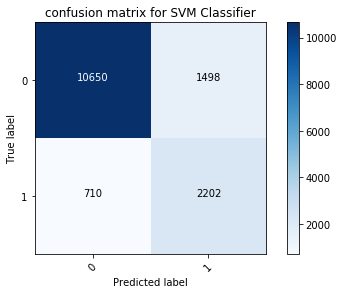

In [27]:
# 使用混淆图函数
types = ['0', '1']
plot_confusion_matrix(svm_confusion_matrix, classes=types, normalize=False,
                      title='confusion matrix for SVM Classifier')

In [28]:
lgbm_confusion_matrix = confusion_matrix(predict_test_y_lgbm, y_test)


Confusion matrix, without normalization
[[10747  1351]
 [  613  2349]]


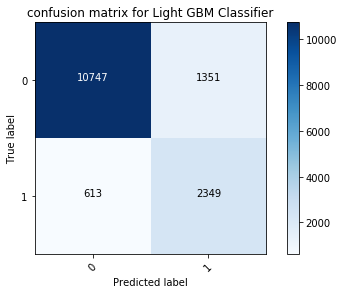

In [29]:
# 使用混淆图函数
types = ['0', '1']
plot_confusion_matrix(lgbm_confusion_matrix, classes=types, normalize=False,
                      title='confusion matrix for Light GBM Classifier')

In [30]:
xgboost_confusion_matrix = confusion_matrix(predict_test_y_xgboost, y_test)

Confusion matrix, without normalization
[[10790  1476]
 [  570  2224]]


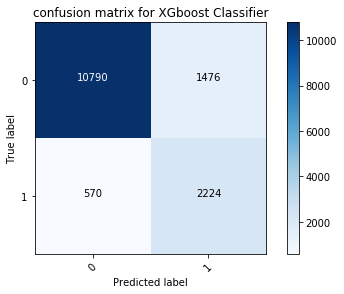

In [31]:
# 使用混淆图函数
types = ['0', '1']
plot_confusion_matrix(xgboost_confusion_matrix, classes=types, normalize=False,
                      title='confusion matrix for XGboost Classifier')

Text(0.5, 1.0, 'LGBM vs XGboost vs SVM')

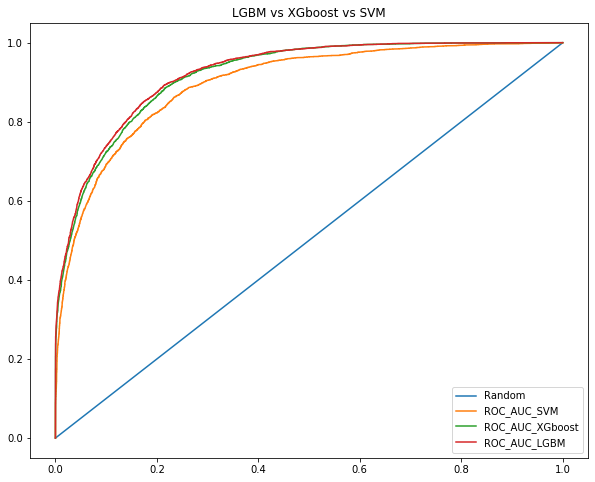

In [34]:
# 查看ROC-AUC曲线

yprob_svm = clf.predict_proba(x_test)
yprob_svm = [x[1] for x in yprob_svm]
fpr,tpr,threshold = roc_curve(y_test,yprob_svm)

yprob_lgbm = lgbm.predict_proba(x_test)
yprob_lgbm = [x[1] for x in yprob_lgbm]
fpr1,tpr1,threshold1 = roc_curve(y_test,yprob_lgbm)

yprob_xgboost = xgboost.predict_proba(x_test)
yprob_xgboost = [x[1] for x in yprob_xgboost]
fpr2,tpr2,threshold2 = roc_curve(y_test,yprob_xgboost)

plt.figure(figsize=(10,8))
plt.plot((0,1),(0,1), label='Random')
plt.plot(fpr,tpr, label='ROC_AUC_SVM')
plt.plot(fpr2, tpr2, label='ROC_AUC_XGboost')
plt.plot(fpr1, tpr1, label='ROC_AUC_LGBM')

plt.legend(loc='best')
plt.title("LGBM vs XGboost vs SVM")

